# UKG to CMiC Integration Middleware
This python project pulls time entry data from UKG Time Management (UTM) along with associated employee information, transforms it into the necessary format for upload to CMiC pytimesheets, and posts the entries. Check log files for errors.

In [1]:
import utm_load
from datetime import datetime

startdate = datetime(2025,8,24)
startdate_str = startdate.strftime("%Y-%m-%d")
enddate = datetime(2025,9,6)
PAYGROUPID = 18 #HJRC
#PAYGROUPID = 43 #HJRU

utm_load.load_ukg(startdate, enddate, PAYGROUPID)

trying OrgLevel1...record counts for OrgLevel1:298
trying OrgLevel2...record counts for OrgLevel2:598
trying OrgLevel3...record counts for OrgLevel3:149
trying OrgLevel4...record counts for OrgLevel4:1
trying Location...record counts for Location:326
trying Paygroup...record counts for Paygroup:41
trying Project...record counts for Project:515
trying Job...record counts for Job:1075
trying Employee...record count for Employee: 2065
trying Time...record count for Time: 2138


[    OrgLevel1_Name         OrgLevel1_Description
 Id                                              
 2           ORGLV1  Default Organization Level 1
 3           000034     Paschal's Restaurant Mgmt
 4           300057         Fly Burger Management
 5           000010     Paschal's Restaurant Mgmt
 6               AH           Allen Hills-Manager
 ..             ...                           ...
 295          BANQT                       Banquet
 296            BAR                           Bar
 297          KITCH                       Kitchen
 298             FD                    Front Desk
 299          90011                        HQ-DEI
 
 [298 rows x 2 columns],
     OrgLevel2_Name         OrgLevel2_Description
 Id                                              
 2           ORGLV2  Default Organization Level 2
 5           VHB03A     Vill@Castleberry Res Srvc
 6           VHB06A          Vill@Castleberry Mgr
 7           VHB07A     Vill@Castleberry Asst Mgr
 8           VHB08B    

In [2]:
from cmic import load_cmic_projects
load_cmic_projects()


Requesting offset 0...Retrieved 500 records — hasMore: True
Requesting offset 500...Retrieved 500 records — hasMore: True
Requesting offset 1000...Retrieved 500 records — hasMore: True
Requesting offset 1500...Retrieved 177 records — hasMore: False
No more pages. Loaded 1677 items
Saved filtered project data to DataFiles/CMiC_Project_Summary.csv


In [3]:
from cmic import employee_push
employee_push(startdate_str)

Requesting offset 0...Retrieved 151 records — hasMore: False
No more pages. Loaded 151 items
📦 Found 5 matching employees. Starting POSTs...

Requesting offset 0...Retrieved 268 records — hasMore: False
No more pages. Loaded 268 items
writing 5 records to file


In [9]:
from cmic import post_timesheets_to_CMiC
import pandas as pd
import matplotlib as mpl
df_timesheet_post_results = post_timesheets_to_CMiC('B',testing=True)

Post log written to DataFiles/PostResult/PostResults_09152025_084056.csv


In [10]:
df_timesheet_post_results.describe(include='all')

,EmpNo,WorkDate,PrnCode,Status,Response,Hours,SourceFile
count,27.000000,27,27,27.000000,27,27.000000,27
unique,NaN,6,1,NaN,6,NaN,1
top,NaN,2025-09-08,W,NaN,{ },NaN,PostResults_09152025_084056.csv
freq,NaN,5,27,NaN,22,NaN,27
mean,223576.703704,NaN,NaN,237.851852,NaN,5.925926,NaN
std,25.823089,NaN,NaN,78.773631,NaN,3.572609,NaN
min,223543.000000,NaN,NaN,201.000000,NaN,0.000000,NaN
25%,223550.000000,NaN,NaN,201.000000,NaN,4.000000,NaN
50%,223588.000000,NaN,NaN,201.000000,NaN,8.000000,NaN
75%,223601.000000,NaN,NaN,201.000000,NaN,8.000000,NaN


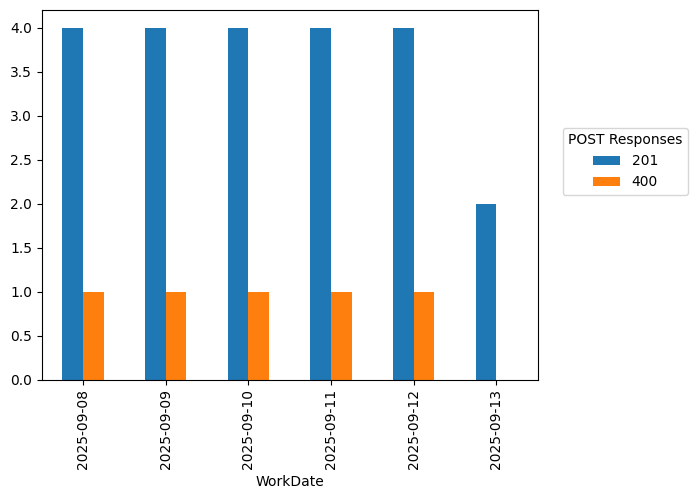

In [11]:
plot_data = df_timesheet_post_results.pivot_table(index='WorkDate',columns='Status',values='Hours',aggfunc='count')
chart = plot_data.plot(kind='bar')\
        .legend(loc=(1.05,0.5))\
        .set_title('POST Responses')
chart

In [7]:
df_timesheet_post_results.loc[df_timesheet_post_results["Status"]=="400"]

,EmpNo,WorkDate,PrnCode,Status,Response,Hours,SourceFile


In [8]:
df_timesheet_post_results.loc[df_timesheet_post_results["Status"]=="201"].Status.value_counts()

Series([], Name: count, dtype: int64)